In [14]:
%matplotlib inline
import numpy as np
import pandas
import matplotlib.pyplot as plt

# Gold-MSI

{'MS01_01': (5.470588235294118, 1.8139039880926917, 6.0),
 'MS02_01': (5.607843137254902, 2.030151971617833, 7.0),
 'MS03_01': (5.287581699346405, 2.264349571459352, 7.0),
 'MS04_01': (5.61437908496732, 2.0459336531871926, 7.0),
 'MS05_01': (5.313725490196078, 1.786169778263023, 6.0)}

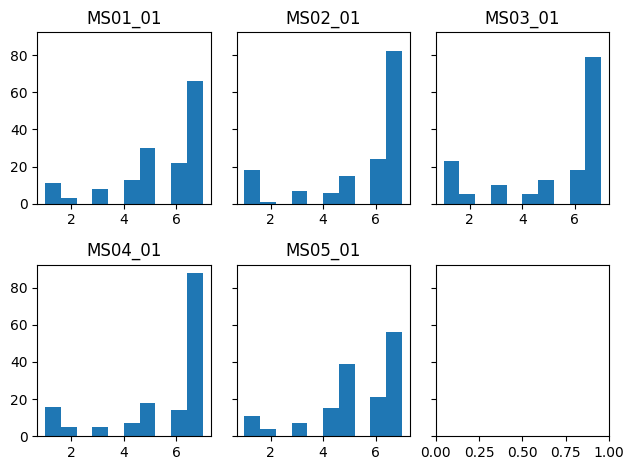

In [15]:
fn = "data/data_listening_experiment.csv"

data = pandas.read_csv(fn, 
                       delimiter=",",
                       engine='c', encoding='utf16')
data= data.dropna(subset=['SERIAL'])
data.set_index('CASE', inplace=True)

msi_columns = ['MS01_01', 'MS02_01', 'MS03_01', 'MS04_01', 'MS05_01']
valid_idxs = [set(np.where(data[c] > 0)[0]) for c in msi_columns]
valid_idxs = list(valid_idxs[0].intersection(*valid_idxs[1:]))
# print(len(valid_idxs))

fig, axes = plt.subplots(2, 3, sharey=True)

msi_stats = dict()
for i, col in enumerate(msi_columns):
    
    vals = data.iloc[list(valid_idxs)][col]
    msi_stats[col] = (vals.mean(), vals.std(), vals.median())
    axes[i // 3, i % 3].hist(data.iloc[list(valid_idxs)][col])
    axes[i // 3, i % 3].set_title(col)

plt.tight_layout()
msi_stats

# Comparisons

In [16]:
import re
from collections import defaultdict
fn_ptt = re.compile(r'MP3_(.+)_normalized/(.+)_segment_([0-9]+)_([0-9]+)(.*)/(.+)_p([0-9]+).match.mp3')
pr_ptt = re.compile(r'_([a-z]+)_([0-9]+)')
#https://silter.gitlab.io/performance/audio/MP3_4x22_normalized/Chopin_op10_no3_segment_0_6/Chopin_op10_no3_p01.match.mp3
#https://silter.gitlab.io/performance/audio/MP3_OUT_normalized/Chopin_op10_no3_segment_0_6_velocity_90/Chopin_op10_no3_p05.match.mp3


def parse_filename(fn, param = 'param'):
    g = fn_ptt.search(str(fn))
    if g is not None:
        ds, piece, ss, se, par, pz, seg = g.groups()
        if par != '':
            pr, rr = pr_ptt.search(par).groups()
        else:
            pr = param
            rr = 'original'
        return ds, piece, ss, se, pr, rr
    else:
        return [None]*6

params = ['A', 'I', 'T', 'V']
questions = ['10', '20', '30', '40']
piece_per_params = {'A':["Mozart_k331_segment_8_8",'Schubert_D783_no15_segment_0_9'], 
                    'I':['Chopin_op38_segment_33_12', 'Schubert_D783_no15_segment_17_8'], # timing
                    'T':['Chopin_op38_segment_33_13', 'Schubert_D783_no15_segment_0_9'], # tempo
                    'V':['Chopin_op10_no3_segment_0_6', 'Schubert_D783_no15_segment_17_8' ] }
feature_per_params = {'A':"Articulation", 
                    'I':"Timing", # timing
                    'T':"Tempo", # tempo
                    'V':"Velocity"}

Info = defaultdict(dict)
for pp in params:
    for level in [50, 90]:
        Info[pp][level] = {
                            "number_answers": 0,
                            "number_dontknow": 0,
                            "number_correct":0,
                              }
        for piece in piece_per_params[pp]:
            Info[pp][level][piece] = {
                            "number_answers": 0,
                            "number_dontknow": 0,
                            "number_correct":0,
                              }

for pp in params:
    for qq in questions:
        q = pp + qq
        # print(q)
        for e1, e2, r, true_r in zip(data[q + '2_01'].values, 
                         data[q + '2_02'].values, 
                         data[q + '1'].values,
                         data[q + '2_03'].values):
    
            
            # print( r, true_r)
            # OUT or 4x22, rr = "original" or "param"
            ds1, piece1, ss1, se1, _, rr1 = parse_filename(e1)
            ds2, piece2, ss2, se2, _, rr2 = parse_filename(e2)
            
            if ds1 is None or ds2 is None:
                pass
            else:
                try:
                    # index of original perf
                    rp_idx = [ds1, ds2].index('4x22')

                    rra = np.array([rr1, rr2])
                    noise_level = int(rra[np.where(rra != 'original')])
                    crr = (r - 1) == rp_idx
                    piece_name = "_".join([piece1, "segment", ss1, se1])
                    piece_name2 = "_".join([piece2, "segment", ss2, se2])

                    if crr: 
                        Info[pp][noise_level]["number_correct"] += 1
                        Info[pp][noise_level][piece_name]["number_correct"] += 1
                    elif r == -9:
                        Info[pp][noise_level]["number_dontknow"] += 1
                        Info[pp][noise_level][piece_name]["number_dontknow"] += 1

                    Info[pp][noise_level]["number_answers"] += 1
                    Info[pp][noise_level][piece_name]["number_answers"] += 1
                    
                except:
                    pass

In [17]:
# the aggregated dictionary of ratings
Info

defaultdict(dict,
            {'A': {50: {'number_answers': 240,
               'number_dontknow': 4,
               'number_correct': 148,
               'Mozart_k331_segment_8_8': {'number_answers': 113,
                'number_dontknow': 1,
                'number_correct': 78},
               'Schubert_D783_no15_segment_0_9': {'number_answers': 127,
                'number_dontknow': 3,
                'number_correct': 70}},
              90: {'number_answers': 185,
               'number_dontknow': 0,
               'number_correct': 139,
               'Mozart_k331_segment_8_8': {'number_answers': 105,
                'number_dontknow': 0,
                'number_correct': 75},
               'Schubert_D783_no15_segment_0_9': {'number_answers': 80,
                'number_dontknow': 0,
                'number_correct': 64}}},
             'I': {50: {'number_answers': 215,
               'number_dontknow': 1,
               'number_correct': 126,
               'Chopin_op38_segme

In [18]:
from scipy.stats import binom

def binomial_exact_test(values):
    k = sum(values)
    n = len(values)
    return binom.pmf(k=k, n=n, p=0.5)
        
        
for pr, cases in Info.items():
    for rr, vals in cases.items():
        print(pr, rr, vals['number_correct']/vals['number_answers']* 100, 
              binom.pmf(k=vals['number_correct'], n=vals['number_answers'], p=0.5))

A 50 61.66666666666667 7.240838368161038e-05
A 90 75.13513513513513 1.5887705651687706e-12
I 50 58.6046511627907 0.0022498005395798592
I 90 54.8936170212766 0.01692125395682095
T 50 68.37209302325581 2.0567032158141917e-08
T 90 78.2051282051282 4.371373179772825e-19
V 50 52.52100840336135 0.03822149299635741
V 90 51.173708920187785 0.05150753119092247
